Sam Schmidt and Chris Stubbs May 30, 2018

Test reading in multiple HSC files, try to make color color diagram
HSC data available at /datasets/hsc/repo/rerun/DM-13666/* where * = UDEEP, DEEP, or WIDE
see some documentation at 
https://confluence.lsstcorp.org/display/DM/S18+HSC+PDR1+reprocessing


In [1]:
import lsst.daf.persistence as daf_persistence
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 8)
import pandas as pd
import glob

In [2]:
depth = 'DEEP' #use the DEEP catalog, got this file path from another notebook
butler = daf_persistence.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
bandlist = ['HSC-G','HSC-R','HSC-I','HSC-Z','HSC-Y'] #grab the main broad bands
bandpaths = []
for band in bandlist:
    infile = glob.glob('/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/%s/10054/0,0/forced_src*'%(band))
    print (infile)
    bandpaths.append(infile)

['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-G/10054/0,0/forced_src-HSC-G-10054-0,0.fits']
['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-R/10054/0,0/forced_src-HSC-R-10054-0,0.fits']
['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-I/10054/0,0/forced_src-HSC-I-10054-0,0.fits']
['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-Z/10054/0,0/forced_src-HSC-Z-10054-0,0.fits']
['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-Y/10054/0,0/forced_src-HSC-Y-10054-0,0.fits']


In [4]:
print (len(bandpaths))

5


For now, let's limit ourselves to one tract, we'll use 100054, let's find all of the patches in this tract.  It turns out Y has the fewest number of processed patches, I'll just use that for now.  Need to fix this later to make sure that the patches included exist in each of the filters!

In [5]:
tract = 10054
band = 'HSC-Y'

In [6]:
files = glob.glob('/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/%s/10054/*/'%(band))
patches = []
for x in files:
    patches.append(x[-4:-1])
print (patches)


['3,0', '0,0', '2,0', '3,1', '1,0', '2,1', '1,1', '2,2', '0,1', '1,2', '0,2']


In [7]:
#help (butler)

Test selection in i-band in terms of good flags?  Or should we do an intersection of good in all bands?

In [8]:
patch = '0,0'
sources = butler.get('deepCoadd_forced_src', tract=tract, patch=patch, filter=band)
src_refs = butler.get('deepCoadd_ref',tract=tract,patch=patch,filter=band)
src_calib = butler.get('deepCoadd_calexp_calib',tract=tract,patch=patch,filter=band)
selection_catalog = src_refs['detect_isPrimary'] \
    & ~sources['base_SdssCentroid_flag'] \
    & ~sources['base_PixelFlags_flag_interpolated'] \
    & ~sources['base_PixelFlags_flag_saturated'] \
    & ~sources['base_PsfFlux_flag'] \
    & ~sources['modelfit_CModel_flag'] 
        

In [9]:
print (selection_catalog)
print (sum(selection_catalog))

[False False False ... False False False]
2340


In [10]:
#patches = ('0,0','3,0')

Now, let's loop over all of the bands and all of the patches in the tract, grab the psf and cmodel magnitudes and errors, along with the extended flag and put them in a pandas dataframe.  We will check for "good" flags in the i-band for each galaxy, so all i-band mags should exist, but there will be some 'NaN's for other bands.  We can do further cuts on magnitude error and such further down

In [11]:
flagfilter = 'HSC-I' #the filter which the "good" flags are set in
df_hsc = 'Null'
df_patchtmp = 'Null'
for band in bandlist:
    df_patch = 'Null'
    for patch in patches:
        psfname = "%s_psf"%(band[4])
        cmname = "%s_cm"%(band[4])
        sources = butler.get('deepCoadd_forced_src', tract=tract, patch=patch, filter=band)
        src_refs = butler.get('deepCoadd_ref',tract=tract,patch=patch,filter=band)
        src_calib = butler.get('deepCoadd_calexp_calib',tract=tract,patch=patch,filter=band)
        src_calib.setThrowOnNegativeFlux(False) #this is necessary to not have the getMagnitude panic when NaNs are returned
        flagrefs = butler.get('deepCoadd_ref',tract=tract,patch=patch,filter=flagfilter)
        flag_sources = butler.get('deepCoadd_forced_src', tract=tract, patch=patch, filter=flagfilter)
        selection_catalog = flagrefs['detect_isPrimary'] \
            & ~flag_sources['base_SdssCentroid_flag'] \
            & ~flag_sources['base_PixelFlags_flag_interpolated'] \
            & ~flag_sources['base_PixelFlags_flag_saturated'] \
            & ~flag_sources['base_PsfFlux_flag'] \
            & ~flag_sources['modelfit_CModel_flag'] 
        print (sum(selection_catalog))
        psf_mag_tup = src_calib.getMagnitude(sources['base_PsfFlux_flux'],sources['base_PsfFlux_fluxSigma'])
        #print (psf_mag)
        cmodel_tup =  src_calib.getMagnitude(sources['modelfit_CModel_flux'],sources['modelfit_CModel_fluxSigma'])
        #print (len(cmodel))
        #cm_mag = coadd_calib.getMagnitude(coadd_forced_src['modelfit_CModel_flux'])
        psfmag = psf_mag_tup[0]
        psfmagerr = psf_mag_tup[1]
        cmodel = cmodel_tup[0]
        cmodelerr = cmodel_tup[1]
        if band == bandlist[-1]: #only add the extended flag for the last filter!
            extend = sources.get('base_ClassificationExtendedness_value')[selection_catalog]
            data = {'%s_psf'%(band[4]): psfmag[selection_catalog], '%s_psferr'%(band[4]): psfmagerr[selection_catalog], 
            '%s_cm'%(band[4]): cmodel[selection_catalog], '%s_cmerr'%(band[4]):cmodelerr[selection_catalog], 'extended': extend}
        else:
            data = {'%s_psf'%(band[4]): psfmag[selection_catalog], '%s_psferr'%(band[4]): psfmagerr[selection_catalog], 
            '%s_cm'%(band[4]): cmodel[selection_catalog], '%s_cmerr'%(band[4]):cmodelerr[selection_catalog]}
        if df_patch is 'Null':            
            df_patch = pd.DataFrame(data=data)
            print (df_patch.shape)
        else:
            df_patchtmp = pd.DataFrame(data=data)
            df_patch = pd.concat([df_patch,df_patchtmp])
            del df_patchtmp
            #pd.concat(df_hsc,df_tmp, axis=1)
            #pd.merge(df_hsc, df_tmp, left_index=True, right_index=True, how='outer')
            print (df_patch.shape)
    if df_hsc is 'Null':
        df_hsc = df_patch
    else: 
        df_hsc = pd.concat([df_hsc, df_patch], axis=1)
        del df_patch

6404
(6404, 4)
3241
(9645, 4)
7103
(16748, 4)
13020
(29768, 4)
7142
(36910, 4)
14282
(51192, 4)
14060
(65252, 4)
12567
(77819, 4)
7366
(85185, 4)
13646
(98831, 4)
6783
(105614, 4)
6404
(6404, 4)
3241
(9645, 4)
7103
(16748, 4)
13020
(29768, 4)
7142
(36910, 4)
14282
(51192, 4)
14060
(65252, 4)
12567
(77819, 4)
7366
(85185, 4)
13646
(98831, 4)
6783
(105614, 4)
6404
(6404, 4)
3241
(9645, 4)
7103
(16748, 4)
13020
(29768, 4)
7142
(36910, 4)
14282
(51192, 4)
14060
(65252, 4)
12567
(77819, 4)
7366
(85185, 4)
13646
(98831, 4)
6783
(105614, 4)
6404
(6404, 4)
3241
(9645, 4)
7103
(16748, 4)
13020
(29768, 4)
7142
(36910, 4)
14282
(51192, 4)
14060
(65252, 4)
12567
(77819, 4)
7366
(85185, 4)
13646
(98831, 4)
6783
(105614, 4)
6404
(6404, 5)
3241
(9645, 5)
7103
(16748, 5)
13020
(29768, 5)
7142
(36910, 5)
14282
(51192, 5)
14060
(65252, 5)
12567
(77819, 5)
7366
(85185, 5)
13646
(98831, 5)
6783
(105614, 5)


let's write this data out to an hdf5 file, as this takes a while to run, comment out so it doesn't write out every time, uncomment to create the file

In [26]:
#outfile_hsc_color = "outfile_10054_grizy.h5"
#df_hsc.to_hdf(outfile_hsc_color, 'df_hsc')

can read this in later with the below line

In [13]:
#df_hsc = pd.read_hdf('outfile_10054_grizy.h5', 'df_hsc')


In [27]:
#help (src_calib)
df_hsc.head()

,G_cm,G_cmerr,G_psf,G_psferr,R_cm,R_cmerr,R_psf,R_psferr,I_cm,I_cmerr,...,I_psferr,Z_cm,Z_cmerr,Z_psf,Z_psferr,Y_cm,Y_cmerr,Y_psf,Y_psferr,extended
0,30.064821,6.744540,27.877673,0.841859,26.692917,0.189936,26.690253,0.183695,25.993736,0.115199,...,0.113273,25.736775,0.165605,25.773944,0.166027,25.495492,0.732214,25.665042,0.819238,1.0
1,26.756039,0.371128,26.973090,0.373494,26.253820,0.157581,26.491903,0.160119,25.527403,0.090158,...,0.092592,25.713036,0.163483,25.935279,0.165364,27.660562,4.870747,28.099225,6.166926,1.0
2,25.891708,0.154158,25.945792,0.141629,25.614567,0.105928,25.816720,0.104505,24.919941,0.062771,...,0.063058,24.286989,0.056791,24.476520,0.057045,NaN,NaN,NaN,NaN,NaN
3,29.314471,4.471010,28.375605,1.330525,26.335085,0.198049,26.779034,0.211313,25.348404,0.111475,...,0.116966,24.981243,0.121448,25.434412,0.135064,NaN,NaN,NaN,NaN,NaN
4,27.121930,0.588344,27.145535,0.520054,25.827951,0.131627,26.060457,0.131305,25.656838,0.125782,...,0.125870,25.201802,0.109871,25.373514,0.111410,26.056207,1.575060,25.951817,1.272116,0.0


In [28]:
df_hsc.tail()

,G_cm,G_cmerr,G_psf,G_psferr,R_cm,R_cmerr,R_psf,R_psferr,I_cm,I_cmerr,...,I_psferr,Z_cm,Z_cmerr,Z_psf,Z_psferr,Y_cm,Y_cmerr,Y_psf,Y_psferr,extended
6778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.877210,0.674560,...,0.709554,33.502410,182.421932,33.694772,203.739551,24.687153,0.265200,24.742725,0.266294,1.0
6779,26.314524,0.259299,26.925411,0.302951,28.289033,1.603815,30.796843,7.940366,26.484533,0.380937,...,0.380763,27.609063,1.580239,29.637903,5.121901,23.428802,0.185735,24.165010,0.198747,1.0
6780,27.095084,0.394901,27.220943,0.411294,27.292073,0.338472,27.349053,0.345381,27.286352,0.440080,...,0.450607,26.663675,0.382863,26.667624,0.371238,27.890781,7.182251,26.712824,2.172613,0.0
6781,NaN,NaN,NaN,NaN,29.460536,3.078424,29.346855,2.250125,27.050749,0.459134,...,0.395063,26.454504,0.387127,26.761488,0.428932,24.496423,0.499033,24.583007,0.467300,1.0
6782,NaN,NaN,NaN,NaN,25.887195,0.441657,31.404930,14.802045,24.200611,0.123978,...,0.215733,24.673130,0.300300,28.878122,3.176679,23.221396,0.519907,26.535439,2.836844,1.0


plot the mag vs error for R-band to make sure that looks sensible

(0, 3)

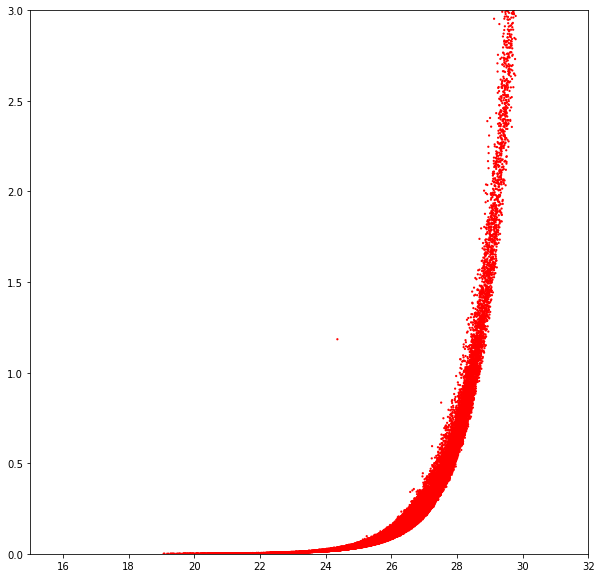

In [29]:
plt.scatter(df_hsc['R_psf'],df_hsc['R_psferr'],s=5,c='r',edgecolor='None')
plt.xlim([15,32])
plt.ylim([0,3])

Create g-r  (PSF) colors for all objects, then make a mask for objects with small i-band error and that are listed as stars (extended==0 is stars extended == 1 is galaxies)

In [94]:
gr = df_hsc['G_psf'] - df_hsc['R_psf']
ri = df_hsc['R_psf'] - df_hsc['I_psf']
mask = np.logical_and(df_hsc['I_psferr']<.1, df_hsc['extended']<0.2)
grcut = gr[mask]
ricut = ri[mask]

(-4, 4)

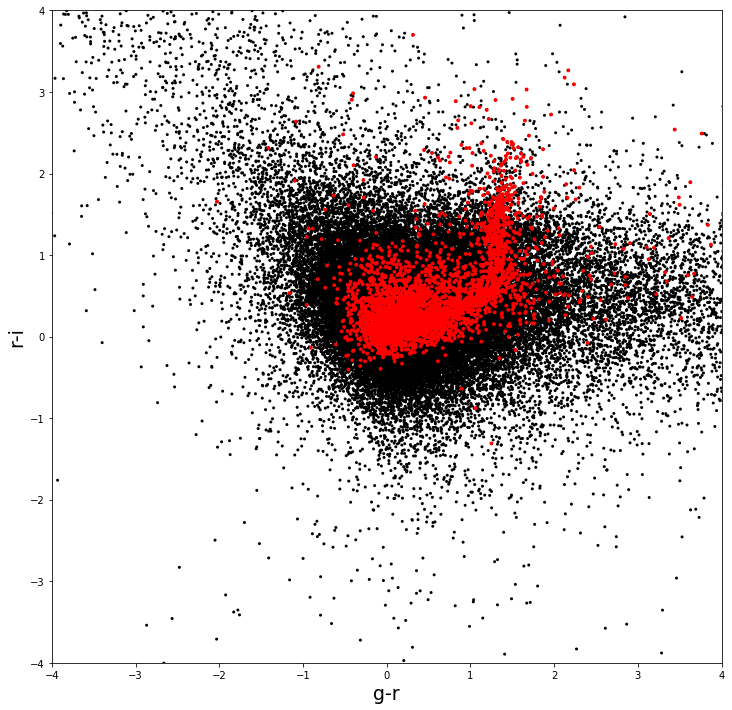

In [95]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.scatter(gr,ri,marker='o',s=9,c='k',edgecolor='none')
plt.scatter(grcut,ricut,marker='o',s=15,c='r',edgecolor='none')
plt.xlabel("g-r",fontsize=19)
plt.ylabel("r-i",fontsize=19)
plt.xlim([-4,4])
plt.ylim([-4,4])

Now make gr and ri for cmodel and compare to the above, with similar cuts

In [103]:
grmod = df_hsc['G_cm'] - df_hsc['R_cm']
rimod = df_hsc['R_cm'] - df_hsc['I_cm']
maskmod = np.logical_and(df_hsc['I_cmerr']<.01, df_hsc['extended']<0.2)
trimdf = df_hsc[maskmod]
grmodcut = trimdf['G_cm']-trimdf['R_cm']
rimodcut = trimdf['R_cm']-trimdf['I_cm']
print (len(grmod),len(rimod),len(grmodcut),len(df_hsc['G_cm']))

105614 105614 691 105614


(-4, 4)

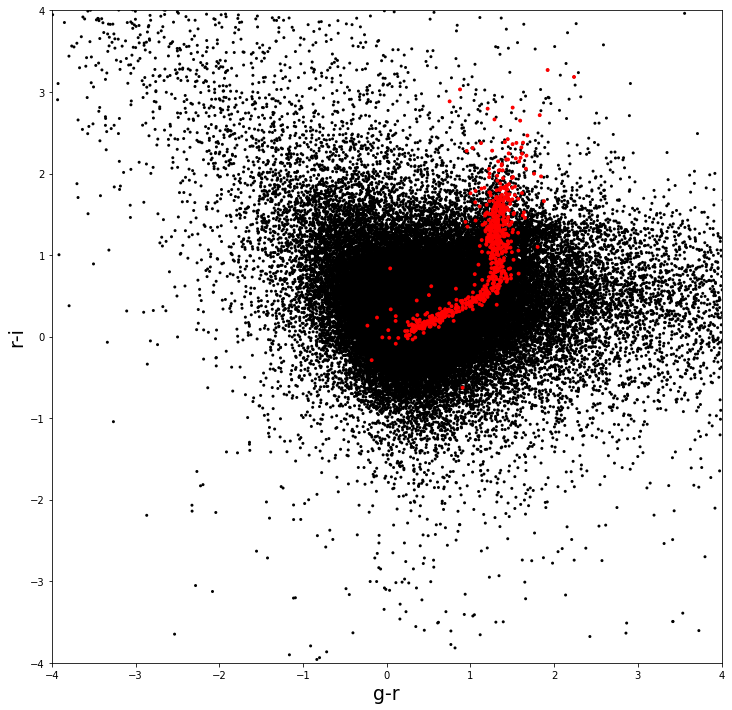

In [104]:
plt.scatter(grmod,rimod,marker='o',s=9,c='k',edgecolor='none')
plt.scatter(grmodcut,rimodcut,marker='o',s=15,c='r',edgecolor='none')
plt.xlabel("g-r",fontsize=19)
plt.ylabel("r-i",fontsize=19)
plt.xlim([-4,4])
plt.ylim([-4,4])


In [100]:
print (len(grmodcut))

691


There is some width to the stellar locus, even for very small (i_err<0.01) selection shown here.  Are the magnitudes corrected for Galactic dust?

Looks like some unextended galaxies are present in addition to the stellar locus, check the extended flag against the difference between PSF and CModel mags to make sure we are doing things sensibly, just do in I-band for now

(-2, 2)

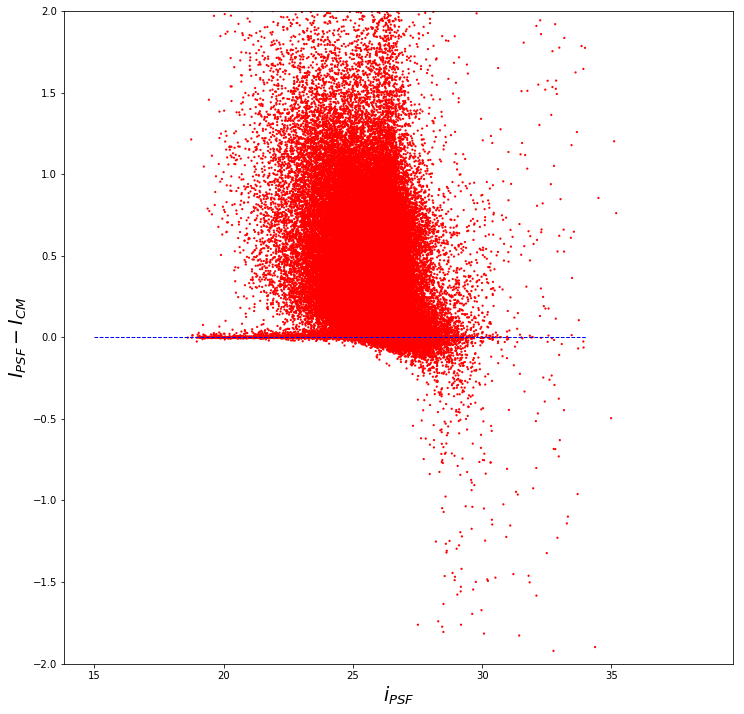

In [44]:
deli = df_hsc['I_psf']-df_hsc['I_cm']
extendedness = df_hsc['extended']
plt.scatter(df_hsc['I_psf'],deli,marker='o',s=5,c='r',edgecolor='none')
plt.plot([15,34],[0,0],linewidth=1,linestyle='--',color='b')
plt.xlabel("$i_{PSF}$",fontsize=19)
plt.ylabel("$I_{PSF}-I_{CM}$",fontsize=19)
plt.ylim([-2,2])

plot extended 0 and 1 separately

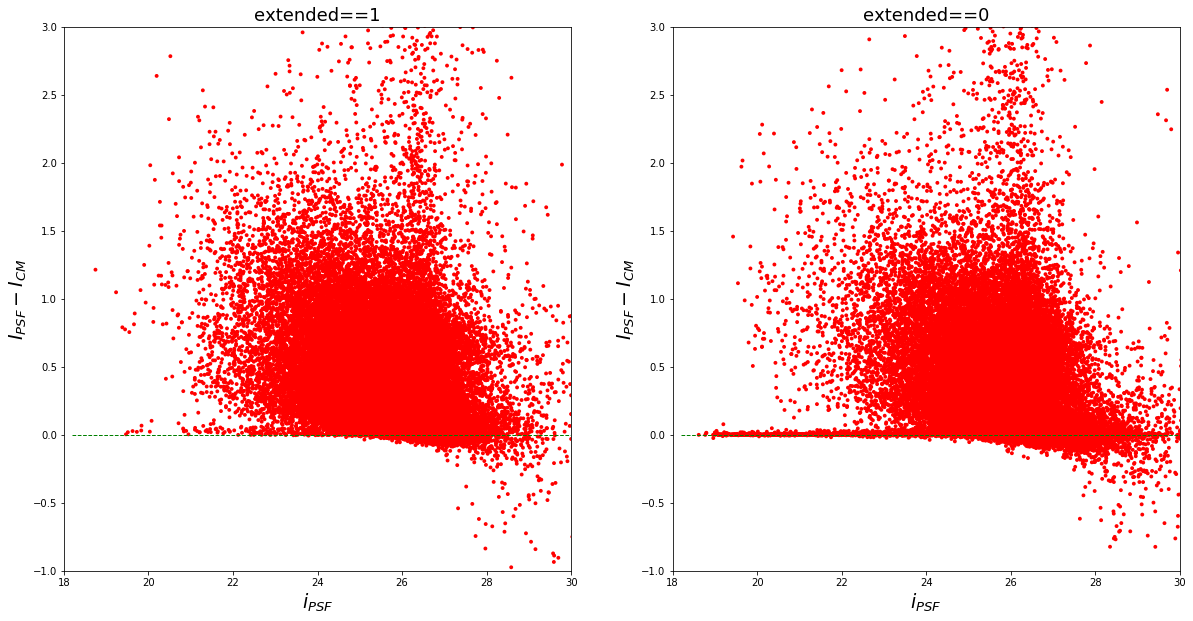

In [67]:
extflag = (extendedness>.4)
#psfcut = df_hsc['I_psf'][extflag]
#delicut = deli[extflag]
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(121)
ax.scatter(df_hsc['I_psf'][extflag],deli[extflag],marker='o',s=15,c='r',edgecolor='none')
#plt.scatter(psfcut,delicut,marker='o',s=5,c='b',edgecolor='None')
ax.plot([18.2,30],[0,0],linewidth=1,linestyle='--',color='g')
plt.xlabel("$i_{PSF}$",fontsize=19)
plt.ylabel("$I_{PSF}-I_{CM}$",fontsize=19)
plt.xlim([18,30])
plt.ylim([-1,3])
plt.title("extended==1", fontsize=18)
noextflag = np.invert(extflag)
bx = plt.subplot(122)
bx.scatter(df_hsc['I_psf'][noextflag],deli[noextflag],marker='o',s=15,c='r',edgecolor='none')
#plt.scatter(psfcut,delicut,marker='o',s=5,c='b',edgecolor='None')
bx.plot([18.2,30],[0,0],linewidth=1,linestyle='--',color='g')
plt.xlabel("$i_{PSF}$",fontsize=19)
plt.ylabel("$I_{PSF}-I_{CM}$",fontsize=19)
plt.xlim([18,30])
plt.ylim([-1,3])
plt.title("extended==0",fontsize=18)
#ax.scatter(deli,extendedness,marker='o',s=9,edgecolor='None',c='r')

In [65]:
print (sum(extflag),sum(noextflag),sum(extflag)+sum(noextflag))

48812 56802 105614


That is with no cuts, add a cut on i-band error as well

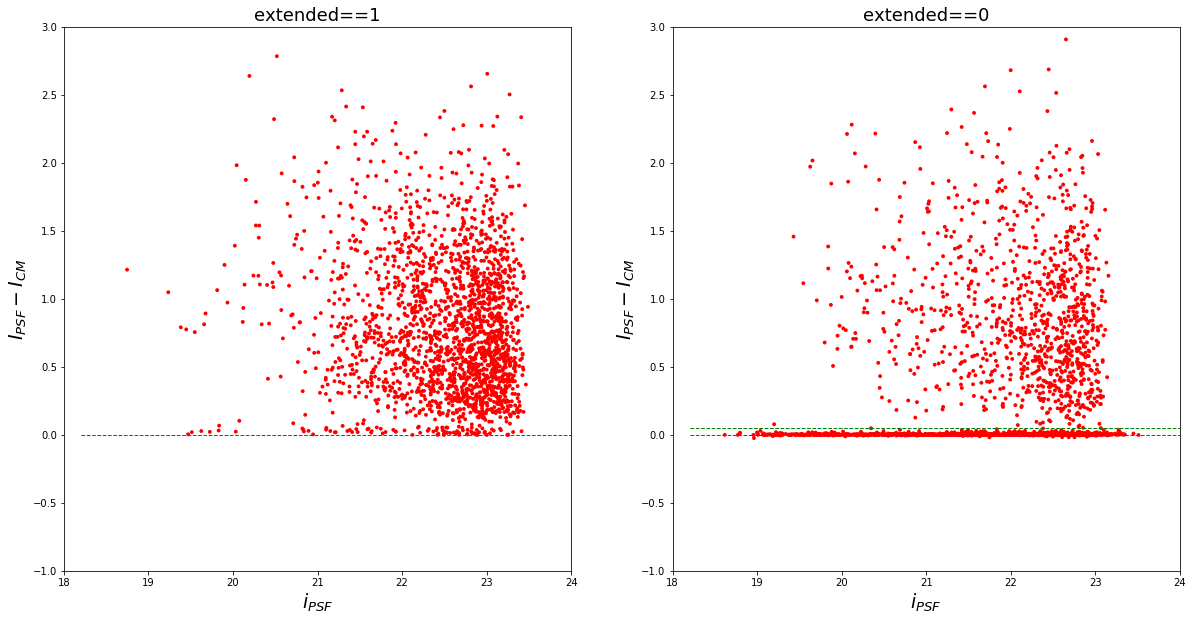

In [106]:
extendmask = (df_hsc['extended']>0.4)
noextmask = np.invert(extendmask)
errmask = np.logical_and(df_hsc['I_psferr']<0.01,extendmask)
noexterrmask = np.logical_and(df_hsc['I_psferr']<0.01,noextmask)

stars = df_hsc[noexterrmask]
gals = df_hsc[errmask]

sipsfcut = stars['I_psf']
gipsfcut = gals['I_psf']
sdelicut = stars['I_psf']-stars['I_cm']
gdelicut = gals['I_psf']-gals['I_cm']

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(121)
ax.scatter(gipsfcut,gdelicut,marker='o',s=15,c='r',edgecolor='none')
#plt.scatter(psfcut,delicut,marker='o',s=5,c='b',edgecolor='None')
ax.plot([18.2,30],[0,0],linewidth=1,linestyle='--',color='g')
plt.xlabel("$i_{PSF}$",fontsize=19)
plt.ylabel("$I_{PSF}-I_{CM}$",fontsize=19)
plt.xlim([18,24])
plt.ylim([-1,3])
plt.title("extended==1", fontsize=18)
noextflag = np.invert(extflag)
bx = plt.subplot(122)
bx.scatter(sipsfcut,sdelicut,marker='o',s=15,c='r',edgecolor='none')
#plt.scatter(psfcut,delicut,marker='o',s=5,c='b',edgecolor='None')
bx.plot([18.2,30],[0,0],linewidth=1,linestyle='--',color='g')
bx.plot([18.2,30],[0.05,0.05],lw=1,linestyle='--',color='g')
plt.xlabel("$i_{PSF}$",fontsize=19)
plt.ylabel("$I_{PSF}-I_{CM}$",fontsize=19)
plt.xlim([18,24])
plt.ylim([-1,3])
plt.title("extended==0",fontsize=18)
#ax.scatter(deli,extendedness,marker='o',s=9,edgecolor='None',c='r')

In [107]:
print (len(sipsfcut))

2222


In [108]:
delii = stars['I_psf']-stars['I_cm']
criteria = np.logical_and(stars['I_psferr']<0.01 ,np.logical_and(stars['extended']<0.1 , delii < 0.05))
cutdf = stars[criteria]

In [109]:
cutdf.head()

,G_cm,G_cmerr,G_psf,G_psferr,R_cm,R_cmerr,R_psf,R_psferr,I_cm,I_cmerr,...,I_psferr,Z_cm,Z_cmerr,Z_psf,Z_psferr,Y_cm,Y_cmerr,Y_psf,Y_psferr,extended
1919,24.388917,0.038252,24.409976,0.037373,23.254632,0.012671,23.260143,0.012649,22.788554,0.008005,...,0.007947,22.549880,0.008829,22.548248,0.008795,22.318961,0.047752,22.314326,0.046900,0.0
1946,22.382571,0.006549,22.379722,0.006144,20.984191,0.001689,20.986582,0.001676,20.050633,0.000818,...,0.000813,19.619889,0.000982,19.617756,0.000975,19.448764,0.004226,19.450770,0.004154,0.0
2435,22.597133,0.006932,22.589172,0.006550,22.229558,0.003633,22.227891,0.003612,22.065844,0.003623,...,0.003602,22.066899,0.005500,22.066845,0.005473,22.011300,0.024034,22.021805,0.024060,0.0
2578,19.677174,0.000897,19.674050,0.000821,19.287437,0.000653,19.286628,0.000647,19.103409,0.000531,...,0.000528,19.121007,0.000682,19.121412,0.000675,19.101294,0.003028,19.104081,0.002980,0.0
3181,22.116395,0.005443,22.116956,0.005044,20.873277,0.001890,20.873144,0.001870,19.473600,0.000719,...,0.000713,18.896994,0.000704,18.895182,0.000693,18.659276,0.002774,18.662742,0.002671,0.0


In [110]:
cutdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691 entries, 1919 to 6069
Data columns (total 21 columns):
G_cm        690 non-null float64
G_cmerr     690 non-null float64
G_psf       691 non-null float64
G_psferr    691 non-null float64
R_cm        691 non-null float64
R_cmerr     691 non-null float64
R_psf       691 non-null float64
R_psferr    691 non-null float64
I_cm        691 non-null float64
I_cmerr     691 non-null float64
I_psf       691 non-null float64
I_psferr    691 non-null float64
Z_cm        691 non-null float64
Z_cmerr     691 non-null float64
Z_psf       691 non-null float64
Z_psferr    691 non-null float64
Y_cm        691 non-null float64
Y_cmerr     691 non-null float64
Y_psf       691 non-null float64
Y_psferr    691 non-null float64
extended    691 non-null float64
dtypes: float64(21)
memory usage: 118.8 KB


(-4, 4)

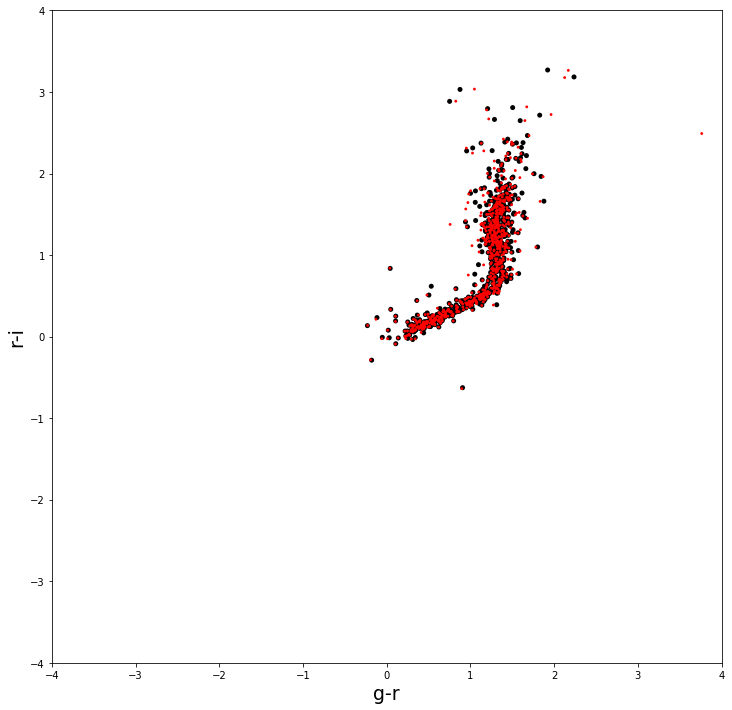

In [111]:
fingr = cutdf['G_psf']-cutdf['R_psf']
finri = cutdf['R_psf']-cutdf['I_psf']
plt.scatter(grmodcut,rimodcut,marker='o',s=25,c='k',edgecolor='none')
plt.scatter(fingr,finri,marker='o',s=8,c='r',edgecolor='none')
plt.xlabel("g-r",fontsize=19)
plt.ylabel("r-i",fontsize=19)
plt.xlim([-4,4])
plt.ylim([-4,4])



I may have screwed up deltai between cmodel and psf, need to work on these cells and making the comparisions

Maybe PSF size or RA/DEC would tell us more about why some galaxies are mareked as not-extended (it may be a mix of galaxies smaller than the PSF and bad seeing or some other effect)

Looks like some non-PSF like objects are included with extended==0, try making an additional cut to select a cleaner sample of stars.  Would need to incorporate psf area in to initial data grab above, which you grab like this:

In [76]:
psfarea = sources.get('base_PsfFlux_area') 

In [78]:
print (psfarea)
print (len(psfarea))

[56.8693   54.314793 56.500286 ... 58.65438  63.636906 63.7206  ]
25854
